# **1. Import des bibliotheques python pour le traitement du fichier**

In [1]:
import pandas as pd
import numpy as np


# **2. Import du fichier .csv dans le notebook et sa visualisation avec la commande df.head()**

In [ ]:
df_athlete = "/content/sample_data/olympic_athletes.csv"
df = pd.read_csv(df_athlete, encoding='latin1', sep=';')
df.head()

,athlete_url,athlete_full_name,games_participations,first_game,athlete_year_birth,athlete_medals,bio
0,https://olympics.com/en/athletes/cooper-woods-...,Cooper WOODS-TOPALOVIC,1,Beijing 2022,2000.0,NaN,NaN
1,https://olympics.com/en/athletes/elofsson,Felix ELOFSSON,2,PyeongChang 2018,1995.0,NaN,NaN
2,https://olympics.com/en/athletes/dylan-walczyk,Dylan WALCZYK,1,Beijing 2022,1993.0,NaN,NaN
3,https://olympics.com/en/athletes/olli-penttala,Olli PENTTALA,1,Beijing 2022,1995.0,NaN,NaN
4,https://olympics.com/en/athletes/reikherd,Dmitriy REIKHERD,1,Beijing 2022,1989.0,NaN,NaN


# **3. Début du traitement du fichier avec une vue sur la nature des colonnes avec la function info()**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19540 entries, 0 to 19539
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   athlete_url           19540 non-null  object 
 1   athlete_full_name     19540 non-null  object 
 2   games_participations  19540 non-null  int64  
 3   first_game            19526 non-null  object 
 4   athlete_year_birth    19427 non-null  float64
 5   athlete_medals        3831 non-null   object 
 6   bio                   1788 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 1.0+ MB


In [ ]:
athlete_year_birth = df['athlete_year_birth'].astype("Int64")

In [ ]:
# Convert the column to string type to apply string methods
df['athlete_medals'] = df['athlete_medals'].astype(str)

# Remove any non-digit characters from the strings
# This will transform strings like '\n\n\n1\n\nS\n\n' into '1', and 'NaN' into ''
df['athlete_medals'] = df['athlete_medals'].str.replace(r'\D', '', regex=True)

# Convert the cleaned strings to numeric, coercing any errors (e.g., empty strings from original NaNs)
# to NaN, as empty strings cannot be converted to numbers.
df['athlete_medals'] = pd.to_numeric(df['athlete_medals'], errors='coerce')

# Fill any remaining NaN values (from original NaNs or values that became empty strings after cleaning) with 0
df['athlete_medals'] = df['athlete_medals'].fillna(0)

# Finally, convert the column to the nullable integer type Int64
df['athlete_medals'] = df['athlete_medals'].astype("Int64")

In [ ]:
df["has_medal"] = df["athlete_medals"].apply(lambda x: 0 if x==0 else 1)
# has_medal a deux valeurs, 1 si l'athlète a déjà eu une médaille et 0 pour non

In [ ]:
df['first_game'].head(20)
df["first_game_year"] = df["first_game"].str.extract(r'(\d{4})').astype(float)

In [ ]:
df["bio"] = df["bio"].fillna("")

In [ ]:
df["athlete_year_birth"] = df["athlete_year_birth"].astype("Int64")
df["age_at_first_game"] = df["first_game_year"] - df["athlete_year_birth"]

In [ ]:
df["first_game_year"] = df["first_game_year"].astype("Int64")
df["athlete_year_birth"] = df["athlete_year_birth"].astype("Int64")
df["age_at_first_game"] = df["age_at_first_game"].astype("Int64")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19540 entries, 0 to 19539
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   athlete_url           19540 non-null  object
 1   athlete_full_name     19540 non-null  object
 2   games_participations  19540 non-null  int64 
 3   first_game            19526 non-null  object
 4   athlete_year_birth    19427 non-null  Int64 
 5   athlete_medals        19540 non-null  Int64 
 6   bio                   19540 non-null  object
 7   has_medal             19540 non-null  int64 
 8   first_game_year       19525 non-null  Int64 
 9   age_at_first_game     19413 non-null  Int64 
dtypes: Int64(4), int64(2), object(4)
memory usage: 1.6+ MB


In [ ]:
df["athlete_year_birth"] = df["athlete_year_birth"].fillna(0)


### 4. Imputation des valeurs manquantes pour l'année de naissance de l'athlète (`athlete_year_birth`)

In [ ]:
# 1. Convertir les 0 en pd.NA pour identifier correctement les valeurs manquantes
df['athlete_year_birth'] = df['athlete_year_birth'].replace(0, pd.NA)

# 2. Tenter d'imputer l'année de naissance si 'first_game_year' et 'age_at_first_game' sont disponibles
# Créer un masque pour les lignes où athlete_year_birth est NA et où les autres colonnes sont non-NA
mask_infer_birth_year = df['athlete_year_birth'].isna() & \
                        df['first_game_year'].notna() & \
                        df['age_at_first_game'].notna()

df.loc[mask_infer_birth_year, 'athlete_year_birth'] = \
    df.loc[mask_infer_birth_year, 'first_game_year'] - \
    df.loc[mask_infer_birth_year, 'age_at_first_game']

# 3. Calculer la médiane des années de naissance valides (non-NA)
median_birth_year = df['athlete_year_birth'].median()

# Remplir les NA restants avec la médiane
df['athlete_year_birth'] = df['athlete_year_birth'].fillna(median_birth_year).astype("Int64")

# 4. Recalculer 'age_at_first_game' pour qu'il soit cohérent avec la nouvelle 'athlete_year_birth'
df['age_at_first_game'] = df['first_game_year'] - df['athlete_year_birth']
df['age_at_first_game'] = df['age_at_first_game'].astype("Int64")

print("Vérification des valeurs manquantes après imputation pour athlete_year_birth et age_at_first_game :")
display(df[['athlete_year_birth', 'first_game_year', 'age_at_first_game']].isnull().sum())

Vérification des valeurs manquantes après imputation pour athlete_year_birth et age_at_first_game :


,0
athlete_year_birth,0
first_game_year,15
age_at_first_game,15


In [ ]:
df.isnull().sum()


,0
athlete_url,0
athlete_full_name,0
games_participations,0
first_game,14
athlete_year_birth,0
athlete_medals,0
bio,0
has_medal,0
first_game_year,15
age_at_first_game,15


### 5. Imputation des valeurs manquantes pour l'âge au premier jeu (`age_at_first_game`)

In [ ]:
# Calculer la médiane des âges au premier jeu valides (non-NA)
median_age_at_first_game = df['age_at_first_game'].median()

# Remplir les NA restants avec la médiane
df['age_at_first_game'] = df['age_at_first_game'].fillna(median_age_at_first_game).astype("Int64")

print("Vérification des valeurs manquantes après imputation pour age_at_first_game :")
display(df[['age_at_first_game']].isnull().sum())

Vérification des valeurs manquantes après imputation pour age_at_first_game :


,0
age_at_first_game,0


### 6. Imputation des valeurs manquantes pour la colonne `first_game`

In [ ]:
# Remplir les valeurs manquantes de 'first_game' avec 'Unknown'
df['first_game'] = df['first_game'].fillna('Unknown')

# Vérifier s'il reste des valeurs manquantes dans 'first_game'
print("Vérification des valeurs manquantes après imputation pour first_game :")
display(df['first_game'].isnull().sum())

# Afficher un aperçu des lignes où 'first_game' était manquant pour vérifier
# Vous pouvez adapter ceci pour voir d'autres colonnes si nécessaire
display(df[df['first_game'] == 'Unknown'].head())

Vérification des valeurs manquantes après imputation pour first_game :


np.int64(0)

,athlete_url,athlete_full_name,games_participations,first_game,athlete_year_birth,athlete_medals,bio,has_medal,first_game_year,age_at_first_game
926,https://olympics.com/en/athletes/mari-eder,Mari EDER,0,Unknown,1987,0,,1,<NA>,24
1595,https://olympics.com/en/athletes/slotins,Roberts SLOTINS,0,Unknown,1991,0,,1,<NA>,24
3447,https://olympics.com/en/athletes/oussama-mellouli,Oussama MELLOULI,0,Unknown,1984,0,,1,<NA>,24
5467,https://olympics.com/en/athletes/cathal-daniels,Cathal DANIELS,0,Unknown,1996,0,,1,<NA>,24
7286,https://olympics.com/en/athletes/klemen-bauer,Klemen BAUER,0,Unknown,1986,0,,1,<NA>,24


### 7. Imputation des valeurs manquantes pour l'année du premier jeu (`first_game_year`)

In [ ]:
# Calculer la médiane des années de premier jeu valides (non-NA)
median_first_game_year = df['first_game_year'].median()

# Remplir les NA restants avec la médiane
df['first_game_year'] = df['first_game_year'].fillna(median_first_game_year).astype("Int64")

print("Vérification des valeurs manquantes après imputation pour first_game_year :")
display(df[['first_game_year']].isnull().sum())

Vérification des valeurs manquantes après imputation pour first_game_year :


,0
first_game_year,0


### 8. Vérification finale des valeurs manquantes dans tout le DataFrame

In [ ]:
df.isnull().sum()

,0
athlete_url,0
athlete_full_name,0
games_participations,0
first_game,0
athlete_year_birth,0
athlete_medals,0
bio,0
has_medal,0
first_game_year,0
age_at_first_game,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19540 entries, 0 to 19539
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   athlete_url           19540 non-null  object
 1   athlete_full_name     19540 non-null  object
 2   games_participations  19540 non-null  int64 
 3   first_game            19540 non-null  object
 4   athlete_year_birth    19540 non-null  Int64 
 5   athlete_medals        19540 non-null  Int64 
 6   bio                   19540 non-null  object
 7   has_medal             19540 non-null  int64 
 8   first_game_year       19540 non-null  Int64 
 9   age_at_first_game     19540 non-null  Int64 
dtypes: Int64(4), int64(2), object(4)
memory usage: 1.6+ MB


# **9. Visualisation du fichier .csv nettoyé et traité**

In [ ]:
df.head()

,athlete_url,athlete_full_name,games_participations,first_game,athlete_year_birth,athlete_medals,bio,has_medal,first_game_year,age_at_first_game
0,https://olympics.com/en/athletes/cooper-woods-...,Cooper WOODS-TOPALOVIC,1,Beijing 2022,2000,0,,0,2022,22
1,https://olympics.com/en/athletes/elofsson,Felix ELOFSSON,2,PyeongChang 2018,1995,0,,0,2018,23
2,https://olympics.com/en/athletes/dylan-walczyk,Dylan WALCZYK,1,Beijing 2022,1993,0,,0,2022,29
3,https://olympics.com/en/athletes/olli-penttala,Olli PENTTALA,1,Beijing 2022,1995,0,,0,2022,27
4,https://olympics.com/en/athletes/reikherd,Dmitriy REIKHERD,1,Beijing 2022,1989,0,,0,2022,33


### 10. Téléchargement du DataFrame nettoyé en fichier CSV

In [ ]:
df.to_csv('olympic_athlete_cleaned.csv', index=False)
print("Le fichier 'olympic_athletes_cleaned.csv' a été téléchargé avec succès.")

In [10]:
df_athlete = "/content/sample_data/olympic_athlete_cleaned.csv"
df_ath = pd.read_csv(df_athlete, encoding='latin1', sep=',')
df_ath.head()

,athlete_url,athlete_full_name,games_participations,first_game,athlete_year_birth,athlete_medals,bio,has_medal,first_game_year,age_at_first_game
0,https://olympics.com/en/athletes/cooper-woods-...,Cooper WOODS-TOPALOVIC,1,Beijing 2022,2000,0,NaN,0,2022,22
1,https://olympics.com/en/athletes/elofsson,Felix ELOFSSON,2,PyeongChang 2018,1995,0,NaN,0,2018,23
2,https://olympics.com/en/athletes/dylan-walczyk,Dylan WALCZYK,1,Beijing 2022,1993,0,NaN,0,2022,29
3,https://olympics.com/en/athletes/olli-penttala,Olli PENTTALA,1,Beijing 2022,1995,0,NaN,0,2022,27
4,https://olympics.com/en/athletes/reikherd,Dmitriy REIKHERD,1,Beijing 2022,1989,0,NaN,0,2022,33


In [4]:
df_medail = "/content/sample_data/medals_clean.csv"
df_medal = pd.read_csv(df_medail, encoding='latin1', sep=',')
df_medal.head()

,year,slug_game,discipline_title,event_gender,medal_type,participant_type,country_name,country_3_letter_code
0,2022,beijing-2022,Curling,Mixed,GOLD,GameTeam,Italy,ITA
1,2022,beijing-2022,Curling,Mixed,GOLD,GameTeam,Italy,ITA
2,2022,beijing-2022,Curling,Mixed,SILVER,GameTeam,Norway,NOR
3,2022,beijing-2022,Curling,Mixed,SILVER,GameTeam,Norway,NOR
4,2022,beijing-2022,Curling,Mixed,BRONZE,GameTeam,Sweden,SWE


In [5]:
df_olymp = "/content/sample_data/olympic_hosts_clean.csv"
df_host = pd.read_csv(df_olymp, encoding='latin1', sep=',')
df_host.head()

,index,game_slug,game_end_date,game_start_date,city,game_name,season,year,season_code,decade,year_norm
0,0,beijing-2022,2022-02-20 13:00:00,2022-02-04 16:00:00,China,Beijing 2022,Winter,2022,1,2020,1.000000
1,1,tokyo-2020,2021-08-08 16:00:00,2021-07-23 13:00:00,Japan,Tokyo 2020,Summer,2020,0,2020,0.984127
2,2,pyeongchang-2018,2018-02-25 09:00:00,2018-02-09 00:00:00,Republic of Korea,PyeongChang 2018,Winter,2018,1,2010,0.968254
3,3,rio-2016,2016-08-21 23:00:00,2016-08-05 14:00:00,Brazil,Rio 2016,Summer,2016,0,2010,0.952381
4,4,sochi-2014,2014-02-23 17:00:00,2014-02-07 05:00:00,Russian Federation,Sochi 2014,Winter,2014,1,2010,0.936508


In [6]:
df_rslt = "/content/sample_data/olympic_results_clean.csv"
df_result = pd.read_csv(df_rslt, encoding='latin1', sep=',')
df_result.head()

,Unnamed: 0,discipline_title,event_title,slug_game,participant_type,medal_type,athletes,rank_equal,rank_position,country_name,country_code,country_3_letter_code,athlete_url,athlete_full_name,value_unit,value_type,medal_code,num_athletes,year
0,0,Curling,Mixed Doubles,beijing-2022,GameTeam,GOLD,"[('Stefania CONSTANTINI', 'https://olympics.co...",False,1,Italy,IT,ITA,NaN,NaN,NaN,NaN,3,2,2022
1,1,Curling,Mixed Doubles,beijing-2022,GameTeam,SILVER,"[('Kristin SKASLIEN', 'https://olympics.com/en...",False,2,Norway,NO,NOR,NaN,NaN,NaN,NaN,2,2,2022
2,2,Curling,Mixed Doubles,beijing-2022,GameTeam,BRONZE,"[('Almida DE VAL', 'https://olympics.com/en/at...",False,3,Sweden,SE,SWE,NaN,NaN,NaN,NaN,1,2,2022
3,3,Curling,Mixed Doubles,beijing-2022,GameTeam,NaN,"[('Jennifer DODDS', 'https://olympics.com/en/a...",False,4,Great Britain,GB,GBR,NaN,NaN,NaN,NaN,0,2,2022
4,4,Curling,Mixed Doubles,beijing-2022,GameTeam,NaN,"[('Rachel HOMAN', 'https://olympics.com/en/ath...",False,5,Canada,CA,CAN,NaN,NaN,NaN,NaN,0,2,2022


In [7]:
df_host.isnull().sum()

,0
index,0
game_slug,0
game_end_date,0
game_start_date,0
city,0
game_name,0
season,0
year,0
season_code,0
decade,0


In [8]:
df_result.isnull().sum()

,0
Unnamed: 0,0
discipline_title,0
event_title,0
slug_game,0
participant_type,0
medal_type,142598
athletes,154828
rank_equal,0
rank_position,3878
country_name,0


In [11]:
df_ath.isnull().sum()

,0
athlete_url,0
athlete_full_name,0
games_participations,0
first_game,0
athlete_year_birth,0
athlete_medals,0
bio,17752
has_medal,0
first_game_year,0
age_at_first_game,0


In [12]:
df_medal.isnull().sum()

,0
year,0
slug_game,0
discipline_title,0
event_gender,0
medal_type,0
participant_type,0
country_name,0
country_3_letter_code,0


In [13]:
games_cols = ['game_slug', 'year', 'game_name', 'season', 'city']
events_cols = ['year','slug_game','discipline_title','event_gender','participant_type',
               'medal_type','country_3_letter_code']
athletes_cols = ['athlete_url','athlete_full_name','games_participations','first_game_year',
                 'age_at_first_game','athlete_medals','has_medal']
results_cols = ['discipline_title','event_title','slug_game','participant_type','medal_type',
                'athletes','rank_position','country_3_letter_code','athlete_url','athlete_full_name',
                'medal_code','num_athletes','year']
games = df_host[games_cols]
events = df_medal[events_cols]
athletes = df_ath[athletes_cols]
results = df_result[results_cols]

In [14]:
athletes = athletes.drop_duplicates(subset=['athlete_url'])
results = results.drop_duplicates(subset=['athlete_url','year','event_title'])


In [15]:
athletes['has_medal'] = athletes['has_medal'].fillna(0)
athletes['athlete_medals'] = athletes['athlete_medals'].fillna(0)
athletes['games_participations'] = athletes['games_participations'].fillna(0)
athletes['age_at_first_game'] = athletes['age_at_first_game'].fillna(athletes['age_at_first_game'].median())
athletes['first_game_year'] = athletes['first_game_year'].fillna(athletes['first_game_year'].median())
# Convert 'rank_position' to numeric, coercing errors to NaN
results['rank_position'] = pd.to_numeric(results['rank_position'], errors='coerce')
results['rank_position'] = results['rank_position'].fillna(results['rank_position'].max() + 1)
results['num_athletes'] = results['num_athletes'].fillna(0)
results['medal_code'] = results['medal_code'].fillna(0)

In [78]:
df_fusion = results.merge(athletes, on=['athlete_url','athlete_full_name'], how='left')

# Prepare host information to merge 'season' into df_fusion
host_info = df_host[['game_slug', 'year', 'season']].rename(columns={'game_slug': 'slug_game'})

# Merge season information into df_fusion
df_fusion = df_fusion.merge(host_info, on=['slug_game', 'year'], how='left')

# Recalculate these columns after all merges
df_fusion['athlete_experience'] = df_fusion['year'] - df_fusion['first_game_year']
df_fusion['athlete_age'] = df_fusion['age_at_first_game'] + df_fusion['athlete_experience']
df_fusion = df_fusion.sort_values(by=['athlete_url','year'])
df_fusion['cumulative_athlete_medals'] = df_fusion.groupby('athlete_url')['has_medal'].cumsum() - df_fusion['has_medal']
n_athletes_per_discipline = df_fusion.groupby(["country_3_letter_code","year"])["discipline_title"].nunique()


In [82]:
n_athletes_per_discipline.head(20)

country_3_letter_code  year
AFG                    1960    2
                       1964    1
                       1968    1
                       1972    1
                       1980    2
                       1988    1
                       1996    1
                       2004    2
                       2008    1
                       2012    3
                       2016    1
                       2020    2
AHO                    1960    1
                       1964    1
                       1968    1
                       1972    2
                       1976    1
                       1984    2
                       1988    3
                       1992    2
Name: discipline_title, dtype: int64

In [79]:
df_fusion.head()

,discipline_title,event_title,slug_game,participant_type,medal_type,athletes,rank_position,country_3_letter_code,athlete_url,athlete_full_name,...,year,games_participations,first_game_year,age_at_first_game,athlete_medals,has_medal,season,athlete_experience,athlete_age,cumulative_athlete_medals
68828,Shooting,50m pistol 60 shots men,barcelona-1992,Athlete,NaN,NaN,28.0,IRQ,https://olympics.com/en/athletes/a-aziz-hassan...,A-Aziz Hassan JALOOF,...,1992,NaN,NaN,NaN,NaN,NaN,Summer,NaN,NaN,NaN
62266,Shooting,10m air pistol 60 shots men,atlanta-1996,Athlete,NaN,NaN,44.0,IRQ,https://olympics.com/en/athletes/a-aziz-hassan...,A-Aziz Hassan JALOOF,...,1996,NaN,NaN,NaN,NaN,NaN,Summer,NaN,NaN,NaN
60580,Athletics,marathon men,atlanta-1996,Athlete,NaN,NaN,111.0,AFG,https://olympics.com/en/athletes/a-baser-wasiqi,A Baser WASIQI,...,1996,NaN,NaN,NaN,NaN,NaN,Summer,NaN,NaN,NaN
133600,Shooting,trap 125 targets men,paris-1900,Athlete,NaN,NaN,28.0,FRA,https://olympics.com/en/athletes/a-darnis,A. DARNIS,...,1900,NaN,NaN,NaN,NaN,NaN,Summer,NaN,NaN,NaN
126748,Tennis,Singles women,paris-1924,Athlete,NaN,NaN,4.0,FRA,https://olympics.com/en/athletes/a-germaine-go...,A. Germaine GOLDING,...,1924,NaN,NaN,NaN,NaN,NaN,Summer,NaN,NaN,NaN


In [80]:
df_fusion.isnull().sum()

,0
discipline_title,0
event_title,0
slug_game,0
participant_type,0
medal_type,118138
athletes,134237
rank_position,0
country_3_letter_code,0
athlete_url,4822
athlete_full_name,1663


In [97]:
athletes_per_discipline = (
    df_fusion.groupby(["year", "country_3_letter_code", "discipline_title"])["athlete_url"]
    .nunique()
    .reset_index(name="athletes_in_discipline")
)
#somme totale d’athlètes envoyés dans toutes les disciplines
athletes_per_discipline_sum = ( athletes_per_discipline.groupby(["year", "country_3_letter_code"])["athletes_in_discipline"] .sum() .reset_index(name="total_athletes_by_discipline") )

In [101]:
athletes_per_discipline.head(20)

,year,country_3_letter_code,discipline_title,athletes_in_discipline
0,1896,AUS,Athletics,1
1,1896,AUS,Tennis,1
2,1896,AUT,Cycling Track,1
3,1896,AUT,Fencing,1
4,1896,AUT,Swimming,2
5,1896,CHI,Athletics,0
6,1896,DEN,Athletics,3
7,1896,DEN,Fencing,1
8,1896,DEN,Gymnastics Artistic,1
9,1896,DEN,Shooting,3


In [130]:
#nombre de disciplines dans lesquelles le pays a envoyé au moins 1 athlète
disciplines_count = (
    athletes_per_discipline.groupby(["year", "country_3_letter_code"])["discipline_title"]
    .nunique()
    .reset_index(name="n_disciplines_with_athletes")
)


In [131]:
disciplines_count.head(20)

,year,country_3_letter_code,n_disciplines_with_athletes
0,1896,AUS,2
1,1896,AUT,3
2,1896,CHI,1
3,1896,DEN,6
4,1896,FRA,6
5,1896,GBR,8
6,1896,GER,6
7,1896,GRE,10
8,1896,HUN,6
9,1896,MIX,1


In [102]:
athletes_per_discipline_sum.head(20)

,year,country_3_letter_code,total_athletes_by_discipline
0,1896,AUS,2
1,1896,AUT,4
2,1896,CHI,0
3,1896,DEN,11
4,1896,FRA,14
5,1896,GBR,11
6,1896,GER,18
7,1896,GRE,59
8,1896,HUN,9
9,1896,MIX,0


In [19]:
# Création des colonnes dérivées pour les médailles
df_fusion["gold"]   = (df_fusion["medal_code"] == 3).astype(int)
df_fusion["silver"] = (df_fusion["medal_code"] == 2).astype(int)
df_fusion["bronze"] = (df_fusion["medal_code"] == 1).astype(int)


# Groupby enrichi
country_year = df_fusion.groupby(['year', 'season', 'country_3_letter_code']).agg(

    # Médailles
    total_medals=('has_medal', 'sum'),
    gold_medals=('gold', 'sum'),
    silver_medals=('silver', 'sum'),
    bronze_medals=('bronze', 'sum'),

    # Athlètes
    total_athletes=('athlete_url', 'nunique'),
    medalist_athletes=('has_medal', 'sum'),

    # Expérience & âge
    avg_athlete_experience=('athlete_experience', 'mean'),
    avg_athlete_age=('athlete_age', 'mean'),
    avg_games_participations=('games_participations', 'mean'),

    # Cumul des médailles individuelles
    cumulative_medals=('cumulative_athlete_medals', 'sum'),

    # Diversité sportive
    n_disciplines=('discipline_title', 'nunique'),
    n_events=('event_title', 'nunique')

).reset_index()

# Features dérivées puissantes
country_year["medals_per_athlete"] = (
    country_year["total_medals"] / country_year["total_athletes"].replace(0, 1)
)

country_year["medalist_ratio"] = (
    country_year["medalist_athletes"] / country_year["total_athletes"].replace(0, 1)
)

country_year["gold_ratio"] = (
    country_year["gold_medals"] / country_year["total_medals"].replace(0, 1)
)

country_year["experience_score"] = (
    country_year["avg_athlete_experience"] * country_year["avg_games_participations"]
)


In [21]:
print("Missing values in country_year before imputation:")
country_year.isnull().sum()

Missing values in country_year before imputation:


,0
year,0
season,0
country_3_letter_code,0
total_medals,0
gold_medals,0
silver_medals,0
bronze_medals,0
total_athletes,0
medalist_athletes,0
avg_athlete_experience,2318


In [22]:
# Impute missing values in avg_athlete_experience and avg_athlete_age with their respective medians
median_experience = country_year['avg_athlete_experience'].median()
country_year['avg_athlete_experience'] = country_year['avg_athlete_experience'].fillna(median_experience)

median_games = country_year['avg_games_participations'].median()
country_year['avg_games_participations'] = country_year['avg_games_participations'].fillna(median_experience)

median_age = country_year['avg_athlete_age'].median()
country_year['avg_athlete_age'] = country_year['avg_athlete_age'].fillna(median_age)

print("Missing values in country_year after imputation:")
display(country_year[['avg_athlete_experience', 'avg_athlete_age','avg_games_participations']].isnull().sum())

Missing values in country_year after imputation:


,0
avg_athlete_experience,0
avg_athlete_age,0
avg_games_participations,0


In [23]:
country_year.tail(20)

,year,season,country_3_letter_code,total_medals,gold_medals,silver_medals,bronze_medals,total_athletes,medalist_athletes,avg_athlete_experience,avg_athlete_age,avg_games_participations,cumulative_medals,n_disciplines,n_events,medals_per_athlete,medalist_ratio,gold_ratio,experience_score
3972,2022,Winter,PER,0.0,0,0,0,1,0.0,12.000000,31.000000,3.000000,0.0,1,2,0.000000,0.000000,0.000000,36.000000
3973,2022,Winter,PHI,0.0,0,0,0,1,0.0,4.000000,22.000000,2.000000,0.0,1,2,0.000000,0.000000,0.000000,8.000000
3974,2022,Winter,POL,7.0,0,0,1,52,7.0,4.355556,26.200000,1.766667,35.0,10,39,0.134615,0.134615,0.000000,7.694815
3975,2022,Winter,POR,0.0,0,0,0,3,0.0,0.000000,23.600000,1.000000,0.0,2,5,0.000000,0.000000,0.000000,0.000000
3976,2022,Winter,PUR,0.0,0,0,0,2,0.0,0.000000,23.666667,1.000000,0.0,2,3,0.000000,0.000000,0.000000,0.000000
3977,2022,Winter,ROC,78.0,6,6,9,124,78.0,2.233503,26.588832,1.477157,106.0,13,66,0.629032,0.629032,0.076923,3.299235
3978,2022,Winter,ROU,0.0,0,0,0,14,0.0,3.454545,26.045455,1.863636,0.0,7,21,0.000000,0.000000,0.000000,6.438017
3979,2022,Winter,SLO,14.0,2,2,2,42,14.0,3.350649,26.818182,1.714286,37.0,6,34,0.333333,0.333333,0.142857,5.743970
3980,2022,Winter,SMR,0.0,0,0,0,2,0.0,0.000000,21.000000,1.000000,0.0,1,4,0.000000,0.000000,0.000000,0.000000
3981,2022,Winter,SRB,0.0,0,0,0,2,0.0,10.000000,31.000000,3.500000,0.0,1,4,0.000000,0.000000,0.000000,35.000000


In [24]:
country_year.groupby("season")["year"].max()
country_year

,year,season,country_3_letter_code,total_medals,gold_medals,silver_medals,bronze_medals,total_athletes,medalist_athletes,avg_athlete_experience,avg_athlete_age,avg_games_participations,cumulative_medals,n_disciplines,n_events,medals_per_athlete,medalist_ratio,gold_ratio,experience_score
0,1896,Summer,AUS,0.0,2,0,0,1,0.0,2.000000,25.854497,2.000000,0.0,2,4,0.000000,0.000000,2.000000,NaN
1,1896,Summer,AUT,0.0,2,1,2,3,0.0,2.000000,25.854497,2.000000,0.0,3,8,0.000000,0.000000,2.000000,NaN
2,1896,Summer,CHI,0.0,0,0,0,0,0.0,2.000000,25.854497,2.000000,0.0,1,1,0.000000,0.000000,0.000000,NaN
3,1896,Summer,DEN,0.0,1,2,3,4,0.0,2.000000,25.854497,2.000000,0.0,6,14,0.000000,0.000000,1.000000,NaN
4,1896,Summer,FRA,0.0,5,3,2,10,0.0,2.000000,25.854497,2.000000,0.0,6,18,0.000000,0.000000,5.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3987,2022,Winter,TPE,0.0,0,0,0,4,0.0,13.000000,28.333333,1.500000,0.0,3,6,0.000000,0.000000,0.000000,19.500000
3988,2022,Winter,TUR,0.0,0,0,0,7,0.0,2.000000,23.250000,1.500000,0.0,4,11,0.000000,0.000000,0.000000,3.000000
3989,2022,Winter,UKR,2.0,0,1,0,38,2.0,2.833333,28.319444,1.652778,17.0,12,37,0.052632,0.052632,0.000000,4.682870
3990,2022,Winter,USA,53.0,8,8,4,140,53.0,3.004444,26.493333,1.715556,173.0,13,68,0.378571,0.378571,0.150943,5.154291


In [98]:
country_year = country_year.merge( athletes_per_discipline_sum, on=["year", "country_3_letter_code"], how="left" )

In [132]:
country_year = country_year.merge( disciplines_count, on=["year", "country_3_letter_code"], how="left" )

In [133]:
country_year.isnull().sum()

,0
year,0
season,0
country_3_letter_code,0
total_medals,0
gold_medals,0
silver_medals,0
bronze_medals,0
total_athletes,0
medalist_athletes,0
avg_athlete_experience,0


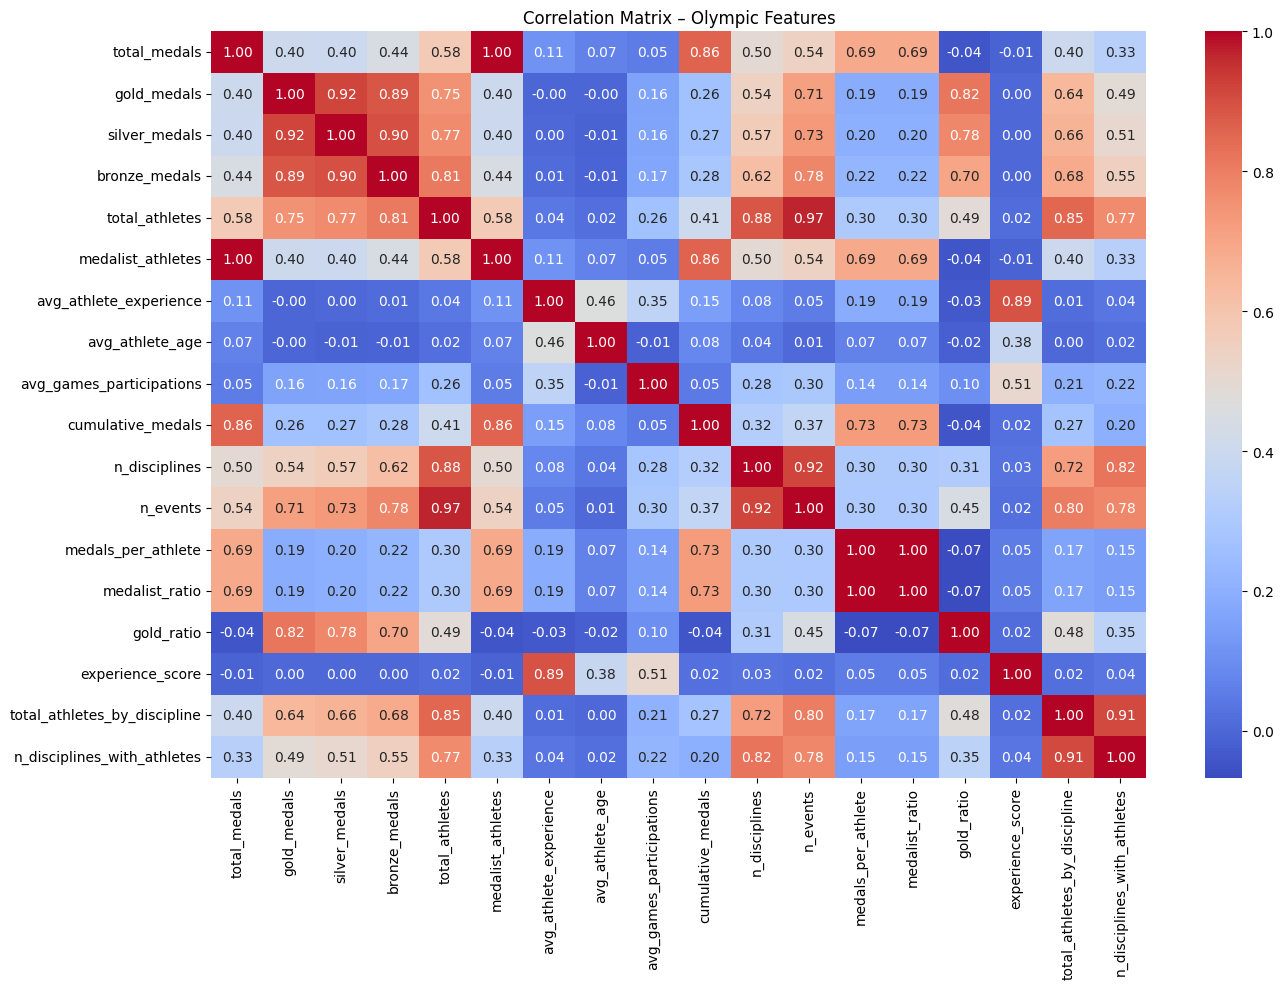

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt

# Liste complète des colonnes numériques pertinentes
numeric_cols = [
    'total_medals',
    'gold_medals', 'silver_medals', 'bronze_medals',
    'total_athletes', 'medalist_athletes',
    'avg_athlete_experience', 'avg_athlete_age',
    'avg_games_participations',
    'cumulative_medals',
    'n_disciplines', 'n_events',
    'medals_per_athlete', 'medalist_ratio',
    'gold_ratio', 'experience_score','total_athletes_by_discipline','n_disciplines_with_athletes'
]

# Filtrer uniquement les colonnes présentes (sécurité)
numeric_cols = [col for col in numeric_cols if col in country_year.columns]

# Matrice de corrélation
corr_matrix = country_year[numeric_cols].corr()

# Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix – Olympic Features")
plt.tight_layout()
plt.show()


In [137]:
invalid_ioc = [ "ROC", "RUS", "SCG", "IOA", "AHO", "XXB", "EOR" ]
country_year_clean = country_year[ ~country_year["country_3_letter_code"].isin(invalid_ioc) ].copy()

In [138]:
# 1. Sélection du dataset d'entraînement (avant 2024)
train = country_year_clean[(country_year_clean["year"] >= 2000) &
                     (country_year_clean["year"] < 2024) &
                     (country_year_clean["season"] == "Summer")]

# 2. Définition de la target
target = "total_medals"

# 3. Liste des features enrichies
features = [
    'total_athletes',
    'medalist_athletes',
    'avg_athlete_age',
    'avg_athlete_experience',
    'avg_games_participations',
    'cumulative_medals',
    'n_disciplines',
    'n_events',
    'medals_per_athlete',
    'medalist_ratio',
    'gold_ratio',
    'experience_score', 'total_athletes_by_discipline','n_disciplines_with_athletes',
    'country_3_letter_code',   # catégorielle
    'season'                   # catégorielle
]

# 4. Extraction X et y
X = train[features]
y = train[target]


In [139]:
X

,total_athletes,medalist_athletes,avg_athlete_age,avg_athlete_experience,avg_games_participations,cumulative_medals,n_disciplines,n_events,medals_per_athlete,medalist_ratio,gold_ratio,experience_score,total_athletes_by_discipline,n_disciplines_with_athletes,country_3_letter_code,season
2338,2,0.0,25.854497,2.00,2.00,0.0,2,3,0.00,0.00,0.000000,NaN,2,2,ALB,Summer
2339,33,0.0,22.000000,0.00,3.00,0.0,8,34,0.00,0.00,1.000000,0.0000,33,8,ALG,Summer
2340,4,0.0,41.500000,14.00,5.00,0.0,3,4,0.00,0.00,0.000000,70.0000,4,3,AND,Summer
2341,4,0.0,34.000000,6.00,4.00,0.0,3,4,0.00,0.00,0.000000,24.0000,4,3,ANG,Summer
2342,1,0.0,25.854497,2.00,2.00,0.0,1,1,0.00,0.00,0.000000,NaN,1,1,ANT,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897,24,6.0,27.640000,1.92,1.48,5.0,13,25,0.25,0.25,0.166667,2.8416,24,13,VEN,Summer
3898,10,1.0,27.000000,2.00,1.50,4.0,7,10,0.10,0.10,0.000000,3.0000,10,7,VIE,Summer
3899,2,0.0,30.500000,0.00,1.00,0.0,2,2,0.00,0.00,0.000000,0.0000,2,2,YEM,Summer
3900,4,0.0,21.000000,0.00,1.00,0.0,2,4,0.00,0.00,0.000000,0.0000,4,2,ZAM,Summer


In [140]:
X = pd.get_dummies(X, columns=['country_3_letter_code','season'], drop_first=True)

In [141]:
X

,total_athletes,medalist_athletes,avg_athlete_age,avg_athlete_experience,avg_games_participations,cumulative_medals,n_disciplines,n_events,medals_per_athlete,medalist_ratio,...,country_3_letter_code_URU,country_3_letter_code_USA,country_3_letter_code_UZB,country_3_letter_code_VAN,country_3_letter_code_VEN,country_3_letter_code_VIE,country_3_letter_code_VIN,country_3_letter_code_YEM,country_3_letter_code_ZAM,country_3_letter_code_ZIM
2338,2,0.0,25.854497,2.00,2.00,0.0,2,3,0.00,0.00,...,False,False,False,False,False,False,False,False,False,False
2339,33,0.0,22.000000,0.00,3.00,0.0,8,34,0.00,0.00,...,False,False,False,False,False,False,False,False,False,False
2340,4,0.0,41.500000,14.00,5.00,0.0,3,4,0.00,0.00,...,False,False,False,False,False,False,False,False,False,False
2341,4,0.0,34.000000,6.00,4.00,0.0,3,4,0.00,0.00,...,False,False,False,False,False,False,False,False,False,False
2342,1,0.0,25.854497,2.00,2.00,0.0,1,1,0.00,0.00,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897,24,6.0,27.640000,1.92,1.48,5.0,13,25,0.25,0.25,...,False,False,False,False,True,False,False,False,False,False
3898,10,1.0,27.000000,2.00,1.50,4.0,7,10,0.10,0.10,...,False,False,False,False,False,True,False,False,False,False
3899,2,0.0,30.500000,0.00,1.00,0.0,2,2,0.00,0.00,...,False,False,False,False,False,False,False,True,False,False
3900,4,0.0,21.000000,0.00,1.00,0.0,2,4,0.00,0.00,...,False,False,False,False,False,False,False,False,True,False


In [142]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [143]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
model_train = XGBRegressor(n_estimators=800, learning_rate=0.03, max_depth=6, subsample=0.8, colsample_bytree=0.8, reg_alpha=1, reg_lambda=2, min_child_weight=3, objective="reg:squarederror", random_state=42)
model_train.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=800,
             n_jobs=None, num_parallel_tree=None, ...)

In [144]:
medal_prediction = model_train.predict(X_test)
print(("mean abs"), mean_squared_error(y_test, medal_prediction))

mean abs 0.4004522204621744


In [145]:
import numpy as np

mse_value = 0.4004522204621744
rmse_value = np.sqrt(mse_value)

print(f"Le RMSE est : {rmse_value}")

Le RMSE est : 0.632812942710699


In [146]:
from sklearn.metrics import mean_absolute_error

mae_value = mean_absolute_error(y_test, medal_prediction)

print(f"Le MAE est : {mae_value}")

Le MAE est : 0.14324385961222824


In [147]:
feature_importances = model_train.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("Top 10 Feature Importances:")
display(importance_df.head(10))

Top 10 Feature Importances:


,Feature,Importance
1,medalist_athletes,0.634195
0,total_athletes,0.134057
6,n_disciplines,0.126203
5,cumulative_medals,0.044908
9,medalist_ratio,0.020713
12,total_athletes_by_discipline,0.014057
8,medals_per_athlete,0.010439
13,n_disciplines_with_athletes,0.005669
7,n_events,0.004555
208,country_3_letter_code_USA,0.001229


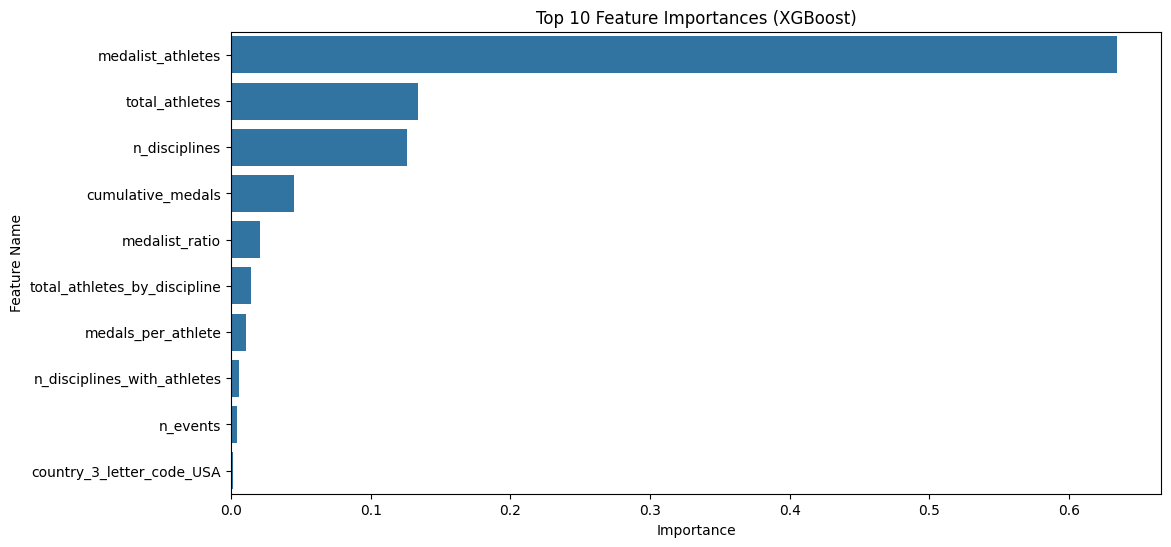

In [148]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.show()

In [149]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from scipy.stats import uniform, randint

print("Modules imported: RandomizedSearchCV, XGBRegressor, uniform, randint")

Modules imported: RandomizedSearchCV, XGBRegressor, uniform, randint


In [150]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 9),
    'learning_rate': uniform(loc=0.01, scale=0.29), # 0.01 to 0.3
    'subsample': uniform(loc=0.6, scale=0.4), # 0.6 to 1.0
    'colsample_bytree': uniform(loc=0.6, scale=0.4) # 0.6 to 1.0
}

xgb_model = XGBRegressor(random_state=42, n_jobs=-1) # Use all available cores

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100, # Number of parameter settings that are sampled
    cv=5, # 5-fold cross-validation
    scoring='neg_mean_squared_error', # Optimize for negative MSE
    verbose=1, # Show progress
    random_state=42,
    n_jobs=-1 # Use all available cores
)

random_search.fit(X_train, y_train)

print("Best hyperparameters found:")
print(random_search.best_params_)
print("Best cross-validation score (negative MSE):")
print(random_search.best_score_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best hyperparameters found:
{'colsample_bytree': np.float64(0.7572390898667042), 'learning_rate': np.float64(0.26869350100136286), 'max_depth': 5, 'n_estimators': 126, 'subsample': np.float64(0.9179245214166594)}
Best cross-validation score (negative MSE):
-0.7621334751531772


In [151]:
best_xgb_model = random_search.best_estimator_

print("Best hyperparameters from RandomizedSearchCV:")
print(random_search.best_params_)

# Best cross-validated score (negative MSE) and convert to RMSE
best_cv_neg_mse = random_search.best_score_
best_cv_rmse = np.sqrt(np.abs(best_cv_neg_mse))
print(f"Best cross-validation RMSE from RandomizedSearchCV: {best_cv_rmse:.4f}")

# Make predictions on the test set using the best estimator
medal_prediction_tuned = best_xgb_model.predict(X_test)

Best hyperparameters from RandomizedSearchCV:
{'colsample_bytree': np.float64(0.7572390898667042), 'learning_rate': np.float64(0.26869350100136286), 'max_depth': 5, 'n_estimators': 126, 'subsample': np.float64(0.9179245214166594)}
Best cross-validation RMSE from RandomizedSearchCV: 0.8730


In [152]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate RMSE for the tuned model
rmse_tuned = np.sqrt(mean_squared_error(y_test, medal_prediction_tuned))
print(f"RMSE for tuned model: {rmse_tuned:.4f}")

# Calculate MAE for the tuned model
mae_tuned = mean_absolute_error(y_test, medal_prediction_tuned)
print(f"MAE for tuned model: {mae_tuned:.4f}")

# Compare with previous results
print("\n--- Comparison with previous model ---")
print(f"Previous RMSE: {rmse_value:.4f}")
print(f"Tuned RMSE:    {rmse_tuned:.4f}")
print(f"Previous MAE:  {mae_value:.4f}")
print(f"Tuned MAE:     {mae_tuned:.4f}")

if rmse_tuned < rmse_value:
    print("Hyperparameter tuning improved RMSE.")
else:
    print("Hyperparameter tuning did not improve RMSE significantly.")

if mae_tuned < mae_value:
    print("Hyperparameter tuning improved MAE.")
else:
    print("Hyperparameter tuning did not improve MAE significantly.")

RMSE for tuned model: 1.0122
MAE for tuned model: 0.1231

--- Comparison with previous model ---
Previous RMSE: 0.6328
Tuned RMSE:    1.0122
Previous MAE:  0.1432
Tuned MAE:     0.1231
Hyperparameter tuning did not improve RMSE significantly.
Hyperparameter tuning improved MAE.


In [153]:
df_2024 = country_year_clean[ (country_year_clean["season"] == "Summer") & (country_year_clean["year"].between(2000, 2020)) ].copy()

In [154]:
df_2024["year"] = 2024
df_2024.shape

(1137, 21)

In [155]:
df_2024_clean = df_2024[ ~df_2024["country_3_letter_code"].isin(invalid_ioc) ].copy()

In [156]:
df_2024_clean.shape

(1137, 21)

In [157]:
df_2024_clean[features].head()

,total_athletes,medalist_athletes,avg_athlete_age,avg_athlete_experience,avg_games_participations,cumulative_medals,n_disciplines,n_events,medals_per_athlete,medalist_ratio,gold_ratio,experience_score,total_athletes_by_discipline,n_disciplines_with_athletes,country_3_letter_code,season
2338,2,0.0,25.854497,2.0,2.0,0.0,2,3,0.0,0.0,0.0,NaN,2,2,ALB,Summer
2339,33,0.0,22.000000,0.0,3.0,0.0,8,34,0.0,0.0,1.0,0.0,33,8,ALG,Summer
2340,4,0.0,41.500000,14.0,5.0,0.0,3,4,0.0,0.0,0.0,70.0,4,3,AND,Summer
2341,4,0.0,34.000000,6.0,4.0,0.0,3,4,0.0,0.0,0.0,24.0,4,3,ANG,Summer
2342,1,0.0,25.854497,2.0,2.0,0.0,1,1,0.0,0.0,0.0,NaN,1,1,ANT,Summer


In [158]:
numeric_features = [f for f in features if f not in ['country_3_letter_code', 'season']]
df_2024_country = df_2024_clean.groupby("country_3_letter_code")[numeric_features].mean().reset_index()

# Since all data in df_2024 has season 'Summer', we can add it back
df_2024_country['season'] = 'Summer'

X_2024 = pd.get_dummies(df_2024_country, columns=['country_3_letter_code', 'season'], drop_first=True)
X_2024 = X_2024.reindex(columns=X_train.columns, fill_value=0)
df_2024_country["predicted_total_medals_2024"] = best_xgb_model.predict(X_2024)
df_2024_country["predicted_total_medals_2024"] = (
    df_2024_country["predicted_total_medals_2024"].round(0).astype(int)
)


In [159]:
output = df_2024_country[[
    "country_3_letter_code",
    "predicted_total_medals_2024"
]].sort_values("predicted_total_medals_2024", ascending=False)

output.to_excel("olympics_2024_predictions_1.xlsx", index=False)


In [129]:
df_real_2022 = country_year_clean[country_year_clean["year"] == 2022][
    ["country_3_letter_code", "total_medals"]
].rename(columns={"total_medals": "real_total_medals_2022"})

comparison = df_2024_country.merge(
    df_real_2022,
    on="country_3_letter_code",
    how="left"
)

comparison["error"] = (
    comparison["predicted_total_medals_2024"]- comparison["real_total_medals_2022"]
)

comparison.to_excel("medals_2024_comparison.xlsx", index=False)
